In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
INPUT_DIM = 10000
LATENT_DIM = 2
DATASET_SIZES = [5, 30, 100, 1000, 5000]
EPOCHS_CONFIG = {5: 50000, 30: 50000, 100: 50000, 1000: 10000, 5000: 10000}
SPARSITY_LEVEL = 0.999

In [36]:
torch.manual_seed(42)
np.random.seed(42)

def generate_dataset(data_dim, num_samples, sparsity=SPARSITY_LEVEL):
    dataset = np.zeros((data_dim, num_samples))

    for i in range(num_samples):
        non_zero_mask = np.random.rand(num_samples) > sparsity

        random_values = np.random.rand(num_samples) * non_zero_mask
        dataset[i] = random_values

        sample_norm = np.linalg.norm(dataset[i]) + 1e-9
        dataset[i] /= sample_norm

    return dataset

In [31]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Model, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim, bias=False)
        self.b = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        h = self.encoder(x)
        out = torch.relu(torch.matmul(h, self.encoder.weight) + self.b)
        return out



def run_training(model, train_data, test_data, num_epochs, lr=1e-3, weight_decay=1e-2):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = nn.MSELoss()

    for epoch in range(num_epochs):
        reconstructed = model(train_data)
        loss = loss_function(reconstructed, train_data)
        loss.backward()
        optimizer.step()

        if epoch % 2000 == 0:
            print(f'Epoch {epoch:5d} | Loss: {loss.item():.4f}')

        optimizer.zero_grad()

    with torch.no_grad():
        final_train_loss = loss_function(model(train_data), train_data).item()
        final_test_loss = loss_function(model(test_data), test_data).item()

    return final_train_loss, final_test_loss

In [32]:
def visualize_results(features, latent_vectors, dataset_sizes):
    fig, axes = plt.subplots(2, len(dataset_sizes), figsize=(18, 10))

    for idx, size in enumerate(dataset_sizes):
        axes[0, idx].scatter(features[idx][:, 0], features[idx][:, 1], s=10)
        axes[0, idx].set_title(f"Features (T={size})")
        axes[0, idx].grid(True)

        axes[1, idx].scatter(latent_vectors[idx][:, 0], latent_vectors[idx][:, 1], s=10, color='r')
        axes[1, idx].set_title(f"Latent Codes (T={size})")
        axes[1, idx].grid(True)

    plt.tight_layout()
    return fig

def plot_loss_curve(dataset_sizes, test_losses):
    plt.figure()
    plt.xscale('log')
    plt.plot(dataset_sizes, test_losses, 'r-o')
    plt.title("Test Loss vs Dataset Size")
    plt.xlabel("Dataset Size (log scale)")
    plt.ylabel("Reconstruction Error")
    plt.grid(True)
    plt.show()


Samples: 5
Epoch     0 | Loss: 0.0001
Epoch  2000 | Loss: 0.0000
Epoch  4000 | Loss: 0.0000
Epoch  6000 | Loss: 0.0000
Epoch  8000 | Loss: 0.0000
Epoch 10000 | Loss: 0.0000
Epoch 12000 | Loss: 0.0000
Epoch 14000 | Loss: 0.0000
Epoch 16000 | Loss: 0.0000
Epoch 18000 | Loss: 0.0000
Epoch 20000 | Loss: 0.0000
Epoch 22000 | Loss: 0.0000
Epoch 24000 | Loss: 0.0000
Epoch 26000 | Loss: 0.0000
Epoch 28000 | Loss: 0.0000
Epoch 30000 | Loss: 0.0000
Epoch 32000 | Loss: 0.0000
Epoch 34000 | Loss: 0.0000
Epoch 36000 | Loss: 0.0000
Epoch 38000 | Loss: 0.0000
Epoch 40000 | Loss: 0.0000
Epoch 42000 | Loss: 0.0000
Epoch 44000 | Loss: 0.0000
Epoch 46000 | Loss: 0.0000
Epoch 48000 | Loss: 0.0000

Samples: 30
Epoch     0 | Loss: 0.0001
Epoch  2000 | Loss: 0.0001
Epoch  4000 | Loss: 0.0001
Epoch  6000 | Loss: 0.0001
Epoch  8000 | Loss: 0.0001
Epoch 10000 | Loss: 0.0001
Epoch 12000 | Loss: 0.0000
Epoch 14000 | Loss: 0.0000
Epoch 16000 | Loss: 0.0000
Epoch 18000 | Loss: 0.0000
Epoch 20000 | Loss: 0.0000
Epo

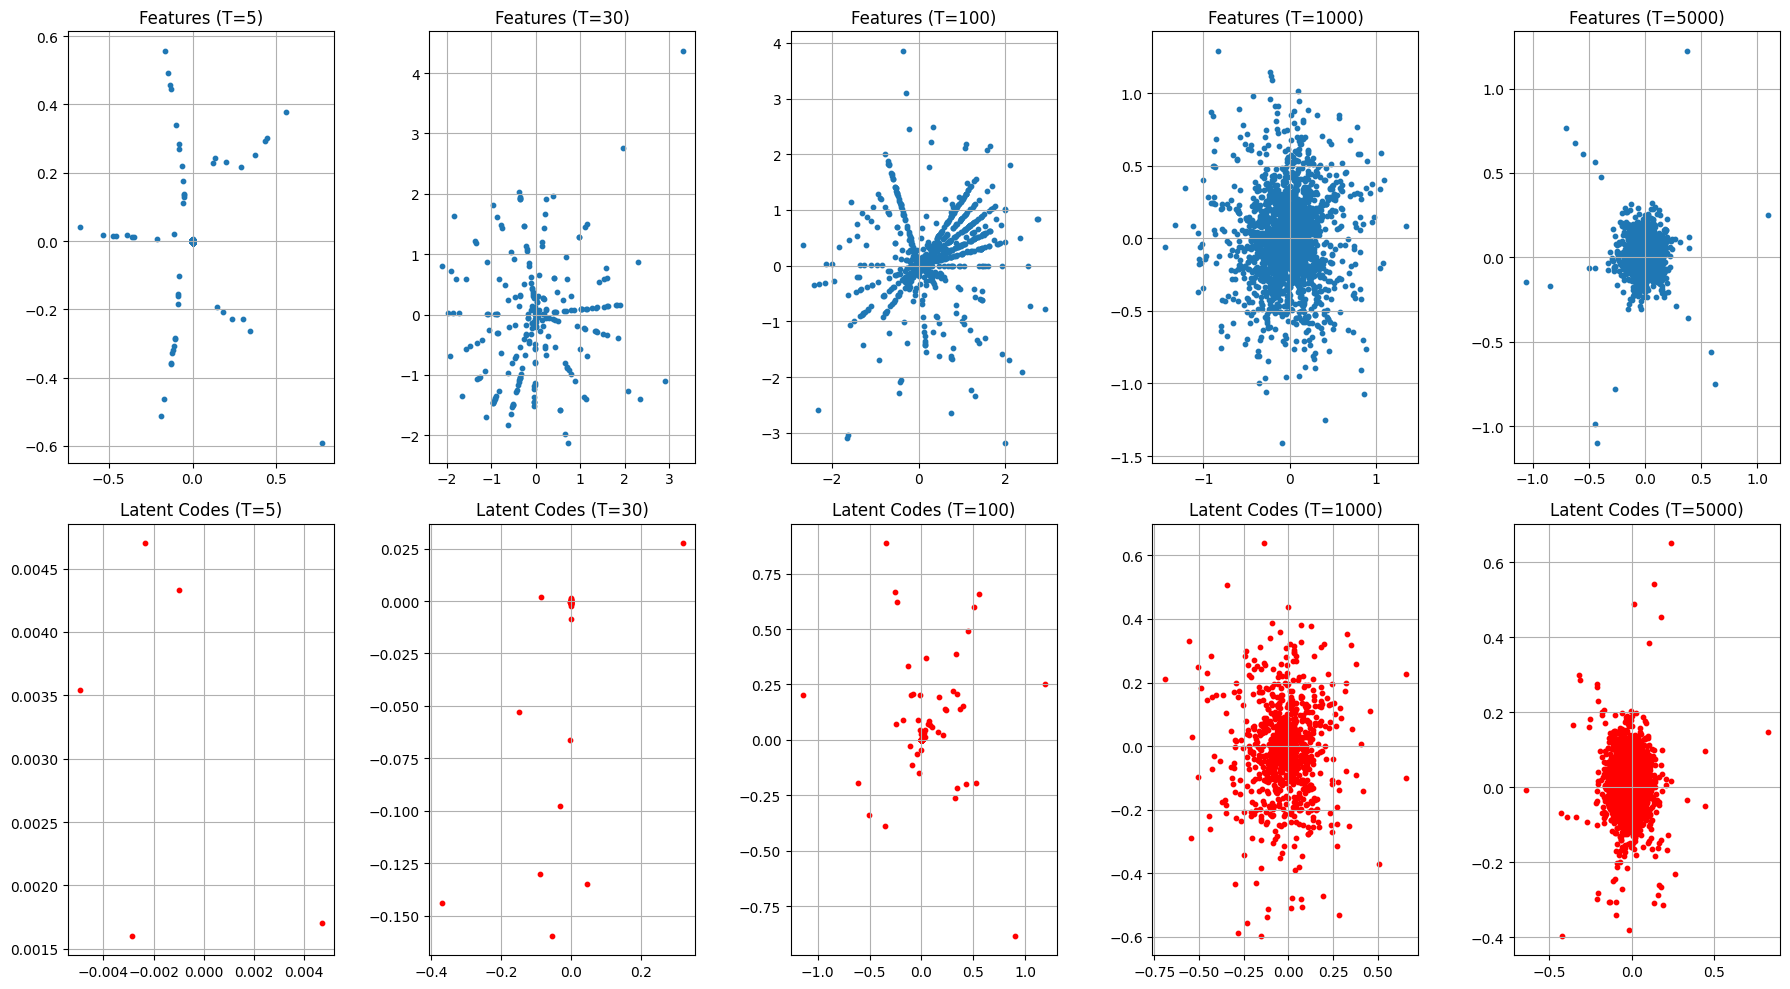

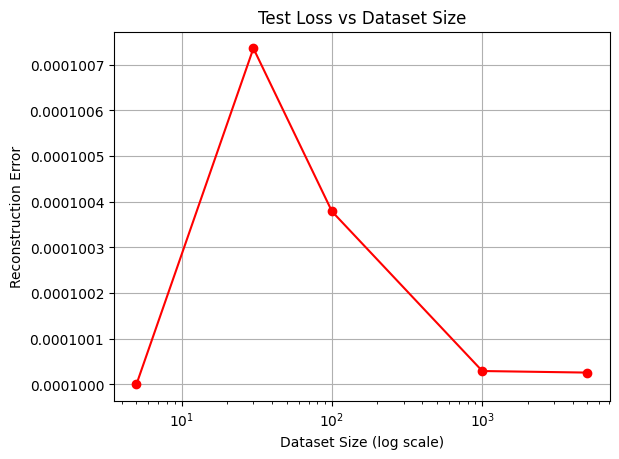

In [35]:
training_losses = []
testing_losses = []
all_features = []
all_latents = []

for dataset_size in DATASET_SIZES:
    print(f"\nSamples: {dataset_size}")

    train_set = generate_dataset(dataset_size, INPUT_DIM)
    test_set = generate_dataset(dataset_size, INPUT_DIM)

    train_tensor = torch.FloatTensor(train_set).to(DEVICE)
    test_tensor = torch.FloatTensor(test_set).to(DEVICE)

    autoencoder = Model(INPUT_DIM, LATENT_DIM).to(DEVICE)
    train_loss, test_loss = run_training(
        autoencoder,
        train_tensor,
        test_tensor,
        num_epochs=EPOCHS_CONFIG[dataset_size]
    )

    training_losses.append(train_loss)
    testing_losses.append(test_loss)

    with torch.no_grad():
        latent_codes = autoencoder.encoder(test_tensor).cpu().numpy()
        learned_features = autoencoder.encoder.weight.T.cpu().numpy()

    all_features.append(learned_features)
    all_latents.append(latent_codes)

visualize_results(all_features, all_latents, DATASET_SIZES)
plot_loss_curve(DATASET_SIZES, testing_losses)